<a href="https://colab.research.google.com/github/dhuanca/Pycon2022/blob/main/SegmentacionPyconBolivia2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo Segmentación cliente 

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 47 kB/s 
     |████████████████████████████████| 199 kB 48.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=895dd7c7fe2719c5eb655d8b09fbff7be7837e996e87cfd054327dcbaf4e49c4
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

Un sparkSession es un punto de entrada para programar Spark con Dataframes (DataFrame API)

El método builder es el constructor de instancias SparkSession

https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.SparkSession.html

In [4]:
spark = SparkSession.builder.appName("Segmentacion").getOrCreate()

Leer de un HDFS que se encuentra en la ruta /user/curso/ el archivo csv: churn_Operacion_2.csv

El Schema se infiere

In [5]:
df_telco = spark.read.csv('/content/churn_Operacion_2.csv', header=True, inferSchema=True)

In [ ]:
df_telco.show(1)

+-----+--------+----------+-------------+-------------------+----------------+----------------------+------------------+----------------+-----------------+------------------+----------------+-----------------+--------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------------------+-------+
|state| account| area_code| phone_number| international_plan| voice_mail_plan| number_vmail_messages| total_day_minutes| total_day_calls| total_day_charge| total_eve_minutes| total_eve_calls| total_eve_charge| total_night_minutes| total_night_calls| total_night_charge| total_intl_minutes| total_intl_calls| total_intl_charge| number_customer_service_calls| churn.|
+-----+--------+----------+-------------+-------------------+----------------+----------------------+------------------+----------------+-----------------+------------------+----------------+-----------------+--------------------+------------------+-------------------

### ¿Que es el esquema?

Es la metadata asociada al dataFrame **df_telco**

In [ ]:
df_telco.printSchema()

root
 |-- state: string (nullable = true)
 |--  account: double (nullable = true)
 |--  area_code: double (nullable = true)
 |--  phone_number: string (nullable = true)
 |--  international_plan: string (nullable = true)
 |--  voice_mail_plan: string (nullable = true)
 |--  number_vmail_messages: double (nullable = true)
 |--  total_day_minutes: double (nullable = true)
 |--  total_day_calls: double (nullable = true)
 |--  total_day_charge: double (nullable = true)
 |--  total_eve_minutes: double (nullable = true)
 |--  total_eve_calls: double (nullable = true)
 |--  total_eve_charge: double (nullable = true)
 |--  total_night_minutes: double (nullable = true)
 |--  total_night_calls: double (nullable = true)
 |--  total_night_charge: double (nullable = true)
 |--  total_intl_minutes: double (nullable = true)
 |--  total_intl_calls: double (nullable = true)
 |--  total_intl_charge: double (nullable = true)
 |--  number_customer_service_calls: double (nullable = true)
 |--  churn.: strin

### ¿Por qué es importante definir un schema?

Es importante porque los modelos por si mismos no identifican si una variable es cuantitativa o cualitativa. Por ejemplo: si la ciudades de Cochabamba y Santa Cruz por los números 1 y 2. Estos valores son númericos? Una computadora los reconoce como numéricos si no se indentifica como texto que es lo que realmente son (cualitativos)


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType, DoubleType, FloatType

In [ ]:
Mischema = StructType(
    [
        StructField('state', StringType(), True),
        StructField('account', StringType(), True),
        StructField('area_code', StringType(), True),
        StructField('phone_number', StringType(), True),
        StructField('international_plan', StringType(), True),
        StructField('voice_mail_plan', StringType(), True),       
        StructField("number_vmail_messages",  DoubleType(), True),
        StructField('total_day_minutes', DoubleType(), True), 
        StructField('total_day_calls', DoubleType(), True),
        StructField('total_day_charge', DoubleType(), True),
        StructField('total_eve_minutes', DoubleType(), True),
        StructField('total_eve_calls', DoubleType(), True),
        StructField('total_eve_charge', DoubleType(), True),
        StructField('total_night_minutes', DoubleType(), True),
        StructField('total_night_calls', DoubleType(), True),
        StructField('total_night_charge', DoubleType(), True),
        StructField('total_intl_minutes', DoubleType(), True),
        StructField('total_intl_calls', DoubleType(), True),
        StructField('total_intl_charge', DoubleType(), True),
        StructField('number_customer_service_calls', DoubleType(), True),
        StructField('churn.', StringType(), True)       
    ]
)

Re leer el dataframe con el schema acordado

In [ ]:
df_telco = spark.read.csv('/user/curso/churn_Operacion_2.csv', header=True, schema=Mischema)

### Explorar datos

Ordenar por columnas 

Ascendente

In [ ]:
df_telco.sort('number_customer_service_calls')[['number_customer_service_calls']].show(5)

+-----------------------------+
|number_customer_service_calls|
+-----------------------------+
|                          0.0|
|                          0.0|
|                          0.0|
|                          0.0|
|                          0.0|
+-----------------------------+
only showing top 5 rows



Descendente

In [ ]:
from pyspark.sql import functions as F

In [ ]:
df_telco.sort(F.desc('number_customer_service_calls'))[['number_customer_service_calls']].show(5)

+-----------------------------+
|number_customer_service_calls|
+-----------------------------+
|                          9.0|
|                          9.0|
|                          8.0|
|                          8.0|
|                          7.0|
+-----------------------------+
only showing top 5 rows



Para verificar el dominio de variables cualitativas se usan funciones de agrupación

In [ ]:
df_telco.groupBy(F.col('area_code')).count().show()

+---------+-----+
|area_code|count|
+---------+-----+
|      408|  838|
|      510|  840|
|      415| 1655|
+---------+-----+



In [ ]:
df_telco.groupBy(F.col('international_plan')).count().show()

+------------------+-----+
|international_plan|count|
+------------------+-----+
|                no| 3010|
|               yes|  323|
+------------------+-----+



In [ ]:
df_telco[['state','number_vmail_messages','number_customer_service_calls']].groupBy(F.col('state')).avg().show()

+-----+--------------------------+----------------------------------+
|state|avg(number_vmail_messages)|avg(number_customer_service_calls)|
+-----+--------------------------+----------------------------------+
|   AZ|                   9.46875|                           1.59375|
|   SC|         8.683333333333334|                1.5833333333333333|
|   LA|         7.901960784313726|                1.5686274509803921|
|   MN|         8.261904761904763|                1.5476190476190477|
|   NJ|         9.191176470588236|                1.6764705882352942|
|   DC|          9.74074074074074|                1.3518518518518519|
|   OR|          6.17948717948718|                1.7307692307692308|
|   VA|         7.038961038961039|                1.5974025974025974|
|   RI|         7.323076923076923|                1.4153846153846155|
|   WY|          6.51948051948052|                1.4415584415584415|
|   KY|                       7.0|                1.7118644067796611|
|   NH|         8.26

In [ ]:
df_telco_pandas = df_telco[['churn','number_customer_service_calls']].groupBy(F.col('churn')).avg().toPandas()

In [ ]:
type(df_telco_pandas)

pandas.core.frame.DataFrame

In [ ]:
type(df_telco)

pyspark.sql.dataframe.DataFrame

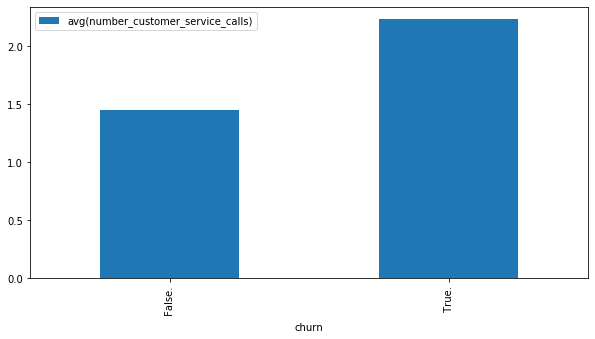

In [ ]:
df_telco_pandas.plot.bar('churn', figsize=(10,5))
plt.show()

In [ ]:
df_telco_pandas = df_telco[['churn','total_day_minutes']].groupBy(F.col('churn')).avg().toPandas()

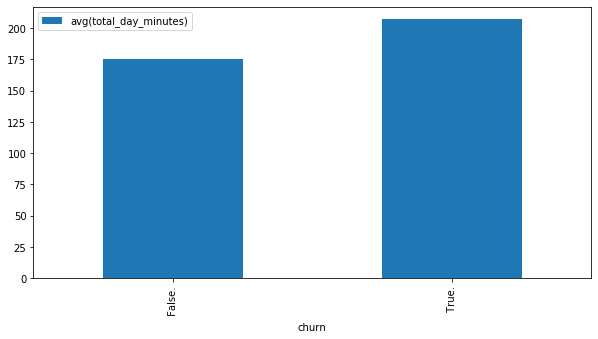

In [ ]:
df_telco_pandas.plot.bar('churn', figsize=(10,5))
plt.show()

##   Transformaciones para refinar datos

###   Renonbrar columnas

La variable churn. contiene un punto al final que podemos eliminarlo

In [ ]:
df_telco = df_telco.withColumnRenamed('churn.','churn')

In [ ]:
df_telco.columns

['state',
 'account',
 'area_code',
 'phone_number',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

In [ ]:
df_telco.printSchema()

root
 |-- state: string (nullable = true)
 |-- account: string (nullable = true)
 |-- area_code: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: double (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: double (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: double (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: double (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: double (nullable = true)
 |-- churn: string (nullable = true)



### Eliminación de valores nulos

In [ ]:
df_telco_describe = df_telco.describe().toPandas()

In [ ]:
df_telco_describe

,summary,state,account,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,count,3333,3333,3333,3333,3333,3333,3333,3333,3333,...,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333
1,mean,None,101.06480648064806,437.18241824182417,None,None,None,8.099009900990099,179.77509750975116,100.43564356435644,...,100.11431143114311,17.083540354035392,200.87203720372048,100.10771077107711,9.039324932493264,10.237293729372933,4.4794479447944795,2.764581458145804,1.5628562856285628,None
2,stddev,None,39.822105928595676,42.37129048560661,None,None,None,13.688365372038598,54.46738920237146,20.069084207300893,...,19.92262529394312,4.310667643110347,50.57384701365836,19.568609346058544,2.275872837660027,2.791839548408416,2.4612142705460953,0.7537726126630451,1.3154910448664752,None
3,min,AK,1,408,327-1058,no,no,0.0,0.0,0.0,...,0.0,0.0,23.2,33.0,1.04,0.0,0.0,0.0,0.0,False.
4,max,WY,99,510,422-9964,yes,yes,51.0,350.8,165.0,...,170.0,30.91,395.0,175.0,17.77,20.0,20.0,5.4,9.0,True.


In [ ]:
df_telco_summary = df_telco.summary().toPandas()

In [ ]:
df_telco_summary

,summary,state,account,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,count,3333,3333,3333,3333,3333,3333,3333,3333,3333,...,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333
1,mean,None,101.06480648064806,437.18241824182417,None,None,None,8.099009900990099,179.77509750975116,100.43564356435644,...,100.11431143114311,17.083540354035392,200.87203720372048,100.10771077107711,9.039324932493264,10.237293729372933,4.4794479447944795,2.764581458145804,1.5628562856285628,None
2,stddev,None,39.822105928595676,42.37129048560661,None,None,None,13.688365372038598,54.46738920237146,20.069084207300893,...,19.92262529394312,4.310667643110347,50.57384701365836,19.568609346058544,2.275872837660027,2.791839548408416,2.4612142705460953,0.7537726126630451,1.3154910448664752,None
3,min,AK,1,408,327-1058,no,no,0.0,0.0,0.0,...,0.0,0.0,23.2,33.0,1.04,0.0,0.0,0.0,0.0,False.
4,25%,None,74.0,408.0,None,None,None,0.0,143.7,87.0,...,87.0,14.16,167.0,87.0,7.52,8.5,3.0,2.3,1.0,None
5,50%,None,101.0,415.0,None,None,None,0.0,179.4,101.0,...,100.0,17.12,201.2,100.0,9.05,10.3,4.0,2.78,1.0,None
6,75%,None,127.0,510.0,None,None,None,20.0,216.4,114.0,...,114.0,20.0,235.3,113.0,10.59,12.1,6.0,3.27,2.0,None
7,max,WY,99,510,422-9964,yes,yes,51.0,350.8,165.0,...,170.0,30.91,395.0,175.0,17.77,20.0,20.0,5.4,9.0,True.


In [ ]:
final_df = df_telco.na.drop()

### Transformación de registros

En general para realizar una transformación a una columna se usa la función withColumn

In [ ]:
final_df.groupBy(F.col('churn')).count().show()

+-------+-----+
|  churn|count|
+-------+-----+
| False.| 2850|
|  True.|  483|
+-------+-----+



In [ ]:
final_df = final_df.withColumn('churn', F.trim(final_df.churn))

In [ ]:
final_df.groupBy(F.col('churn')).count().show()

+------+-----+
| churn|count|
+------+-----+
| True.|  483|
|False.| 2850|
+------+-----+



## Feature engineering

Se realiza una transformación de variables cualitativas

In [ ]:
df_telco_final = final_df.select([
 'state',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 "churn"])

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

one hot encoding State

In [ ]:
state_indexer = StringIndexer(inputCol= 'state', outputCol= 'stateIndex')

In [ ]:
state_encoder = OneHotEncoder(inputCol = 'stateIndex', outputCol= 'stateVec')

one hot encoding area_code

In [ ]:
area_code_indexer = StringIndexer(inputCol='area_code', outputCol= 'area_codeIndex')

In [ ]:
area_code_encoder = OneHotEncoder(inputCol = 'area_codeIndex', outputCol= 'area_codeVec')

one hot encoding international_plan

In [ ]:
international_plan_indexer = StringIndexer(inputCol='international_plan', outputCol= 'international_planIndex')

In [ ]:
international_plan_encoder = OneHotEncoder(inputCol = 'international_planIndex', outputCol= 'international_planVec')

one hot encoding voice_mail_plan

In [ ]:
voice_mail_plan_indexer = StringIndexer(inputCol='voice_mail_plan', outputCol= 'voice_mail_planIndex')

In [ ]:
voice_mail_plan_encoder = OneHotEncoder(inputCol = 'voice_mail_planIndex', outputCol= 'voice_mail_planVec')

In [ ]:
churn_indexer = StringIndexer(inputCol= 'churn', outputCol= 'churnIndex')

In [ ]:
assembler = VectorAssembler(inputCols = ['stateVec', 'area_codeVec', 'international_planVec', 'voice_mail_planVec',
                                        'number_vmail_messages',
                                         'total_day_minutes',
                                         'total_day_calls',
                                         'total_day_charge',
                                         'total_eve_minutes',
                                         'total_eve_calls',
                                         'total_eve_charge',
                                         'total_night_minutes',
                                         'total_night_calls',
                                         'total_night_charge',
                                         'total_intl_minutes',
                                         'total_intl_calls',
                                         'total_intl_charge',
                                         'number_customer_service_calls'
                                        ], outputCol= 'features')

Seleccionando las variables que se usarán en el análisis cluster

In [ ]:
df_telco_final.columns

['state',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

In [ ]:
df_telco_col_seg = df_telco_final.select([
 'state',
 'area_code',
 'international_plan',
 'voice_mail_plan',   
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls'])

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
kmeans = KMeans().setK(5).setSeed(1)

In [ ]:
pipeline = Pipeline(stages= [
    state_indexer,
    area_code_indexer,
    international_plan_indexer,
    voice_mail_plan_indexer,
    state_encoder,
    area_code_encoder,
    international_plan_encoder,
    voice_mail_plan_encoder,
    assembler, 
    kmeans])

In [ ]:
train_data, test_data = final_df.randomSplit([0.7,0.3])

In [ ]:
fit_model = pipeline.fit(train_data)

In [ ]:
type(fit_model)

pyspark.ml.pipeline.PipelineModel

realizar clusterizaciones

In [ ]:
predictions = fit_model.transform(test_data)

In [ ]:
predictions.show(5)

+-----+-------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+------+----------+--------------+-----------------------+--------------------+---------------+-------------+---------------------+------------------+--------------------+----------+
|state|account|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls| churn|stateIndex|area_codeIndex|international_planIndex|voice_mail_planIndex|       stateVec| area_codeVec|international_planVec|voice_mail_p

para observar de mejor manera se puede obtener una muestra y convertirlo en un dataframe Pandas

In [ ]:
predictions_pandas = predictions.sample(fraction=0.5).toPandas()

In [ ]:
predictions_pandas.head()

,state,account,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,stateIndex,area_codeIndex,international_planIndex,voice_mail_planIndex,stateVec,area_codeVec,international_planVec,voice_mail_planVec,features,prediction
0,AK,1,408,373-1028,no,no,0.0,175.2,74.0,29.78,...,45.0,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)",(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,AK,101,510,411-4940,no,no,0.0,174.9,105.0,29.73,...,45.0,2.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)",(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,AK,127,510,345-8237,no,yes,36.0,183.2,117.0,31.14,...,45.0,2.0,0.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0)",(1.0),(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,AK,130,415,392-5587,no,no,0.0,242.5,101.0,41.23,...,45.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)",(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,AK,132,415,345-9153,no,yes,39.0,175.7,93.0,29.87,...,45.0,0.0,0.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)",(1.0),(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [ ]:
predictions.groupBy(F.col('prediction')).count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  184|
|         3|  205|
|         4|  209|
|         2|  209|
|         0|  200|
+----------+-----+



In [ ]:
predictions_pandas['prediction'].value_counts()

2    117
0    117
4    109
3    105
1     97
Name: prediction, dtype: int64

Evaluar mediante el coeficiente de Silhouette

El coeficiente Silhouette se encuentra entre - 1 y 1 siendo lo mejor 1 y lo peor -1, el valor 0 indica que los clusters estan sobreponiendo

In [ ]:
evaluador = ClusteringEvaluator()

In [ ]:
silhouette = evaluador.evaluate(predictions)
print("El coeficiente Silhouette usando distancias euclidianas al cuadrado es = " + str(silhouette))

El coeficiente Silhouette usando distancias euclidianas al cuadrado es = 0.27447674656410437
